In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.quantization as quant
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [45]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization for MNIST
])

In [46]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [47]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after first convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after second convolution
        self.fc1_input_size = 64 * 7 * 7  # Input size for the first fully connected layer (adjust as needed)
        self.fc1 = nn.Linear(self.fc1_input_size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply batch normalization after the first convolution
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # First pooling layer

        x = self.conv2(x)
        x = self.bn2(x)  # Apply batch normalization after the second convolution
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Second pooling layer

        x = torch.flatten(x, 1)  # Flatten the output for fully connected layers
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU activation
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
# Parameters
batch_size = 64
num_epochs = 5
learning_rate = 0.001
k = 5  # K-Fold

In [49]:
def train_model(model, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return running_loss / len(train_loader)

In [50]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    return correct / total

In [51]:
# K-Fold Cross Validation for Quantization
kfold = KFold(n_splits=k, shuffle=True)
non_quantized_accuracies = []
non_quantized_times = []  # To track training times for non-quantized model
quantized_accuracies = {
    "Post-Training Static Quantization": [],
    "Post-Training Dynamic Quantization": [],
    "Quantization-Aware Training": []
}
quantized_times = {
    "Post-Training Static Quantization": [],
    "Post-Training Dynamic Quantization": [],
    "Quantization-Aware Training": []
}

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):    
    print(f'Fold {fold + 1}/{k}')
    
    # Create samplers and dataloaders for training and validation sets
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    # Initialize the model
    model = CNNModel().to(device)

    # Train the model without quantization
    print("Training Non-Quantized Model...")
    start_time = time.time()
    train_model(model, train_loader)
    non_quantized_accuracy = evaluate_model(model, val_loader)
    non_quantized_accuracies.append(non_quantized_accuracy)
    non_quantized_time = time.time() - start_time
    non_quantized_times.append(non_quantized_time)
    print(f'Non-Quantized Accuracy: {non_quantized_accuracy:.4f}, Time: {non_quantized_time:.2f}s')


Fold 1/5
Training Non-Quantized Model...
Non-Quantized Accuracy: 0.9879, Time: 174.95s
Fold 2/5
Training Non-Quantized Model...
Non-Quantized Accuracy: 0.9883, Time: 152.59s
Fold 3/5
Training Non-Quantized Model...
Non-Quantized Accuracy: 0.9862, Time: 190.29s
Fold 4/5
Training Non-Quantized Model...
Non-Quantized Accuracy: 0.9797, Time: 183.04s
Fold 5/5
Training Non-Quantized Model...
Non-Quantized Accuracy: 0.9866, Time: 172.54s


In [52]:
# **1. Post-Training Static Quantization**
model_static = CNNModel().to(device)
model_static.eval()
 # Fuse Conv2d + BatchNorm layers before quantizing
model_static = quant.fuse_modules(model_static, [['conv1', 'bn1'], ['conv2', 'bn2']])
model_static.qconfig = quant.get_default_qconfig('fbgemm')  # Set quantization config for static quantization
quant.prepare(model_static, inplace=True)
print("Training Model after Static Quantization...")
start_time = time.time()
train_model(model_static, train_loader)
accuracy = evaluate_model(model_static, val_loader)
quantized_accuracies["Post-Training Static Quantization"].append(accuracy)
quantized_times["Post-Training Static Quantization"].append(time.time() - start_time)
print(f'Static Quantized Accuracy: {accuracy:.4f}, Time: {quantized_times["Post-Training Static Quantization"][-1]:.2f}s')

c:\Users\mukes\anaconda3\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Training Model after Static Quantization...
Static Quantized Accuracy: 0.9912, Time: 152.86s


In [53]:
 # **2. Post-Training Dynamic Quantization**
model_dynamic = CNNModel().to(device)
model_dynamic.eval()
model_dynamic.qconfig = quant.get_default_qconfig('fbgemm')
quant.prepare(model_dynamic, inplace=True)
print("Training Model after Dynamic Quantization...")
start_time = time.time()
train_model(model_dynamic, train_loader)
accuracy = evaluate_model(model_dynamic, val_loader)
quantized_accuracies["Post-Training Dynamic Quantization"].append(accuracy)
quantized_times["Post-Training Dynamic Quantization"].append(time.time() - start_time)
print(f'Dynamic Quantized Accuracy: {accuracy:.4f}, Time: {quantized_times["Post-Training Dynamic Quantization"][-1]:.2f}s')

Training Model after Dynamic Quantization...
Dynamic Quantized Accuracy: 0.9901, Time: 191.66s


In [54]:
# **3. Quantization-Aware Training (QAT)**
model_qat = CNNModel().to(device)
model_qat.train()
model_qat.qconfig = quant.get_default_qconfig('fbgemm')
quant.prepare_qat(model_qat, inplace=True)
print("Training Model with Quantization-Aware Training...")
start_time = time.time()
train_model(model_qat, train_loader)
accuracy = evaluate_model(model_qat, val_loader)
quantized_accuracies["Quantization-Aware Training"].append(accuracy)
quantized_times["Quantization-Aware Training"].append(time.time() - start_time)
print(f'QAT Model Accuracy: {accuracy:.4f}, Time: {quantized_times["Quantization-Aware Training"][-1]:.2f}s')

Training Model with Quantization-Aware Training...
QAT Model Accuracy: 0.9833, Time: 208.55s


In [55]:
# Create a DataFrame with the comparison data for quantization methods
comparison_data = {
    "Quantization Method": ["Post-Training Static Quantization", "Post-Training Dynamic Quantization", "Quantization-Aware Training", "Non-Quantized"],
    "Accuracy": [np.mean(quantized_accuracies["Post-Training Static Quantization"]),
                 np.mean(quantized_accuracies["Post-Training Dynamic Quantization"]),
                 np.mean(quantized_accuracies["Quantization-Aware Training"]),
                 np.mean(non_quantized_accuracies)],
    "Training Time (s)": [np.mean(quantized_times["Post-Training Static Quantization"]),
                          np.mean(quantized_times["Post-Training Dynamic Quantization"]),
                          np.mean(quantized_times["Quantization-Aware Training"]),
                          np.mean(non_quantized_times)]
}

comparison_df = pd.DataFrame(comparison_data)


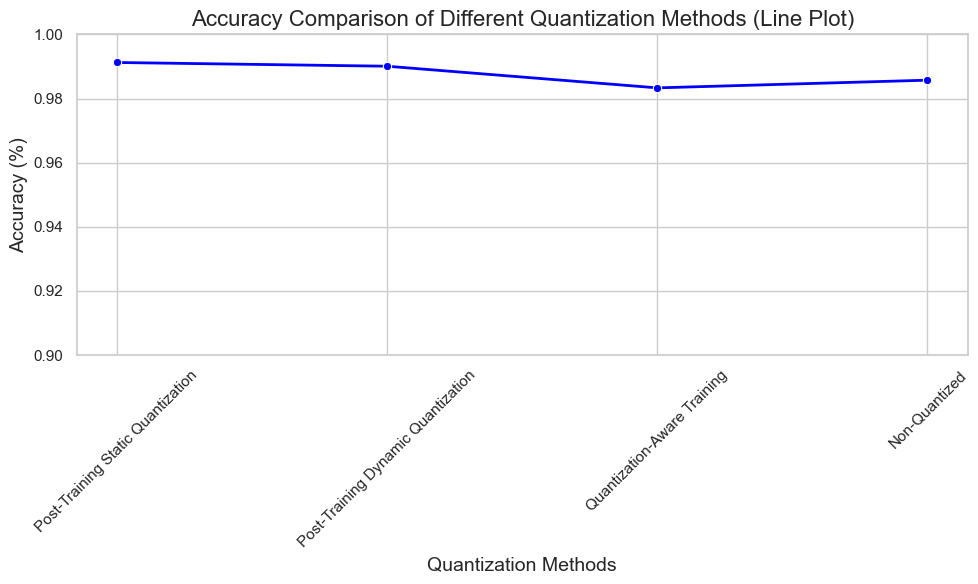

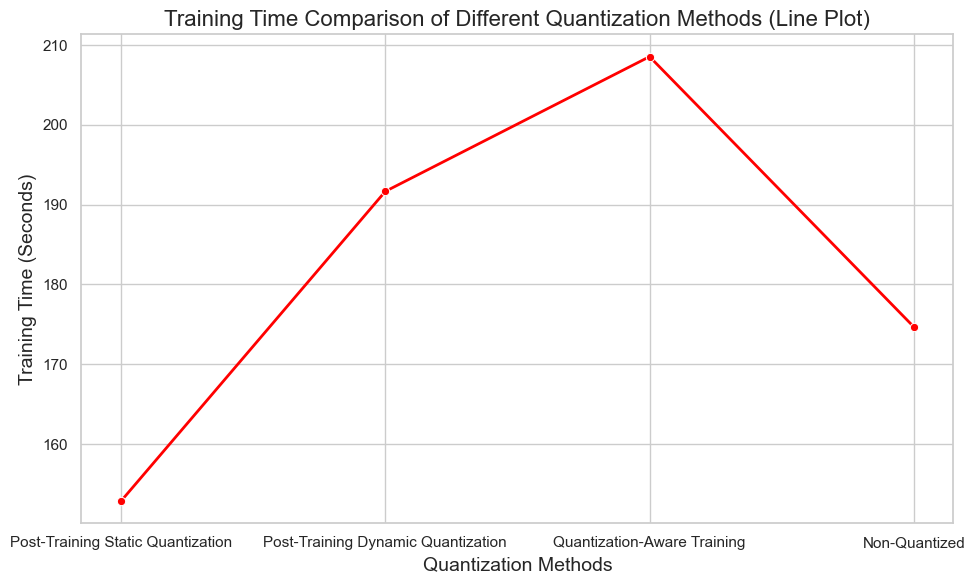

In [58]:
# Plot Accuracy Comparison using Line Plot for clearer differentiation
plt.figure(figsize=(10, 6))
sns.lineplot(x="Quantization Method", y="Accuracy", data=comparison_df, marker='o', color='blue', lw=2)
plt.title('Accuracy Comparison of Different Quantization Methods (Line Plot)', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xlabel('Quantization Methods', fontsize=14)
plt.ylim([0.90, 1.0])  # Adjust y-axis limits to zoom in on minor differences
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Training Time Comparison using Line Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Quantization Method", y="Training Time (s)", data=comparison_df, marker='o', color='red', lw=2)
plt.title('Training Time Comparison of Different Quantization Methods (Line Plot)', fontsize=16)
plt.ylabel('Training Time (Seconds)', fontsize=14)
plt.xlabel('Quantization Methods', fontsize=14)
plt.tight_layout()
plt.show()